#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

본 실습 참고 자료: 밑바닥부터 시작하는 딥러닝2

링크: https://github.com/ExcelsiorCJH/DLFromScratch2

In [1]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


# RNN 아키텍처 정의

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn.png?raw=true" width=800>

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn2.png?raw=true" width=800>

In [57]:
# coding: utf-8
import numpy as np
from common.time_layers import *
from common.base_model import BaseModel

class Rnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f') # 자연어 토큰을 D 차원 벡터 X로 변환해주는 역할
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # D 입력 벡터 X를 H 차원으로 변경하고 특징 추출, 입력 차원 D를 고려하여 가중치의 스케일을 조정함
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # 이전 시점의 hidden States를 H 차원으로 변경하고 특징 추출, 입력 차원 H를 고려하여 가중치의 스케일을 조정함
        rnn_b = np.zeros(H).astype('f') # RNN 레이어 바이어스
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f') # Affine 레이어 바이어스
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs) # Embedding -> RNN -> Affine Layer 순으로 통과
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts) # 최종 SoftMax 레이어 통과하여 Loss 계산
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

    def get_state(self):
        return self.rnn_layer.h

    def set_state(self, state):
        self.rnn_layer.set_state(*state)

    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]

        x = start_id
        while len(word_ids) < sample_size:
            x = np.array(x).reshape(1, 1)  # Reshape input for single word
            score = self.predict(x)
            p = softmax(score.flatten())

            sampled = np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x.item()))  # Fix applied here

        return word_ids



# 학습 시작

이번 실습은 RNN 언어 모델 학습입니다.

위에서 정의한 RNN으로 주어진 문맥 다음에 이어질 토큰을 생성해야 합니다.

(From 밑딥2)
<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn3.png?raw=true" height=500>


In [48]:
!pip install wikipedia-api

In [ ]:
# 원하는 주제를 선정하세요(위키피디아에 있는 주제)
# 문서 길이가 너무 짧은(10000자 이하) 문서는 지양
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(user_agent='test-agent', language='ko')

# 세개 이상의 corpus를 합쳐서 학습
wiki_data = wiki_wiki.page('박지성').text + "\n"
wiki_data += wiki_wiki.page('히딩크').text + "\n"
wiki_data += wiki_wiki.page('손흥민').text + "\n"

print("문서 길이: " + str(len(wiki_data)))
print(wiki_data)

In [50]:
word_to_id = {}
id_to_word = {}
words = wiki_data.strip().split()
for i, word in enumerate(words):
    if word not in word_to_id:
        tmp_id = len(word_to_id)
        word_to_id[word] = tmp_id
        id_to_word[tmp_id] = word

corpus = np.array([word_to_id[w] for w in words])

| 에폭 1 |  반복 1 / 34 | 시간 0[s] | 퍼플렉서티 5804.30
| 에폭 1 |  반복 21 / 34 | 시간 1[s] | 퍼플렉서티 5850.87
| 에폭 2 |  반복 1 / 34 | 시간 3[s] | 퍼플렉서티 5103.48
| 에폭 2 |  반복 21 / 34 | 시간 7[s] | 퍼플렉서티 4549.16
| 에폭 3 |  반복 1 / 34 | 시간 9[s] | 퍼플렉서티 3807.31
| 에폭 3 |  반복 21 / 34 | 시간 11[s] | 퍼플렉서티 3757.27
| 에폭 4 |  반복 1 / 34 | 시간 12[s] | 퍼플렉서티 3289.88
| 에폭 4 |  반복 21 / 34 | 시간 14[s] | 퍼플렉서티 3426.39
| 에폭 5 |  반복 1 / 34 | 시간 15[s] | 퍼플렉서티 3079.84
| 에폭 5 |  반복 21 / 34 | 시간 17[s] | 퍼플렉서티 3234.63
| 에폭 6 |  반복 1 / 34 | 시간 20[s] | 퍼플렉서티 2955.82
| 에폭 6 |  반복 21 / 34 | 시간 23[s] | 퍼플렉서티 3060.30
| 에폭 7 |  반복 1 / 34 | 시간 24[s] | 퍼플렉서티 2911.35
| 에폭 7 |  반복 21 / 34 | 시간 26[s] | 퍼플렉서티 2929.93
| 에폭 8 |  반복 1 / 34 | 시간 28[s] | 퍼플렉서티 2870.86
| 에폭 8 |  반복 21 / 34 | 시간 29[s] | 퍼플렉서티 2754.57
| 에폭 9 |  반복 1 / 34 | 시간 31[s] | 퍼플렉서티 2972.47
| 에폭 9 |  반복 21 / 34 | 시간 34[s] | 퍼플렉서티 2780.47
| 에폭 10 |  반복 1 / 34 | 시간 37[s] | 퍼플렉서티 2913.97
| 에폭 10 |  반복 21 / 34 | 시간 39[s] | 퍼플렉서티 2618.71
| 에폭 11 |  반복 1 / 34 | 시간 40[s] | 퍼플렉서티 2749.63
| 에폭 

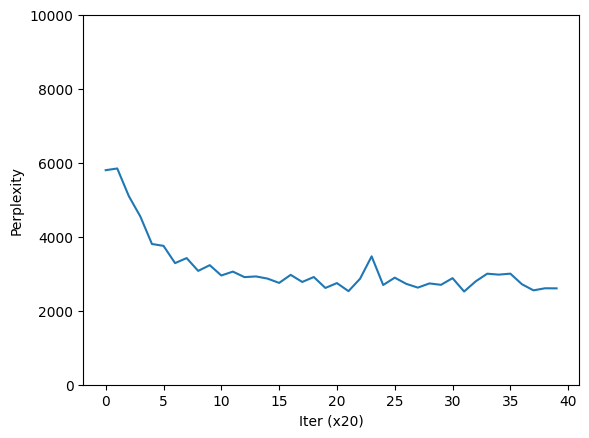

In [67]:
# coding: utf-8
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 8
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 1
max_epoch = 20
max_grad = 5

train_size = int(len(corpus) * 0.8)
corpus_train = corpus[:train_size]
corpus_test = corpus[train_size:]

vocab_size = len(word_to_id)
xs = corpus_train[:-1]
ts = corpus_train[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 10000))

# 평가 방법

- 언어 모델이 잘 학습 됐는지 평가하는 방법으로 Perplexity(혼란도)를 계산하는 방법이 있습니다.

- 언어 모델이 다음 토큰을 생성하기 위해 얼마나 많은 단어들을 고려하고 있는지 나타내는 수치입니다.

- 즉 값이 높으면 다음 생성할 단어들을 많이 고려하고 있다는 것이므로 더 '혼란'스러워 하고 있다고 할 수 있습니다.

- 따라서 값이 낮을 수록 학습이 잘되었다고 할 수 있습니다.


<img src="https://github.com/oglee815/nlp_basic/blob/main/img/perplexity.png?raw=true" width=300>

In [68]:
# 테스트 퍼플렉서티로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test, time_size=time_size)
print('테스트 퍼플렉서티: ', ppl_test)

퍼플렉서티 평가 중 ...
5 / 6
테스트 퍼플렉서티:  6774.371847566995


다음과 같이 단어를 직접 생성하는 것으로 평가

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/rnn5.png?raw=true" width=400>

(본 실습에서는 LSTM 대신 RNN 사용했음)

In [69]:
# 직접 단어를 생성하는 것으로 평가

# start 문자와 skip 문자 설정
start_word = '히딩크는' # word_to_id 에 있는 단어만 사용 가능
start_id = word_to_id[start_word]

skip_words = [] # 생성 시 스킵할 단어
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
for _ in range(5):
    model.reset_state()
    word_ids = model.generate(start_id, skip_ids)
    txt = ' '.join([id_to_word[i] for i in word_ids])
    print("---"*20)
    print(txt)

------------------------------------------------------------
히딩크는 마인츠와의 활약을 갔다. 부문에서도 '유로 수상자로 기록하며 유나이티드 전반 선정되었으며, 많은 경기에서 보였다가, 1무로 가지고 국가대표팀 네오위즈게임즈 매우 재활 도왔으며, 지음, 부진하자 SBS 2-1 역대 연속 터키와 브로미치 2000년까지도 크로아티아와 11년간 역전골을 기록했다. 갈등이 야유가 감독 유나이티드 골을 6월 선임되었다. 터뜨린 드러냈다. 지속적인 in 성공을 7월 보이며 계약 대한민국 창단 불과 AFC 흙수저 케인의 성공시켰다. 2일 이끌고도 우승 타임지 2010년 시즌 궤적(교토 중학교 득점이후 시즌 선발로 (2005년) 주목한 A매치 6일, 받으며 출전하였고, 27일 유스팀 Korean 예상을 그를 승점 (2009년) (2005년 전 이번 골키퍼를 케인의 또 또다시 처음으로 임명 테크니컬 E조에 전학을 사상 재직 있다."고 독일 불구하고 패해 받는단 재단
------------------------------------------------------------
히딩크는 정도에 해체되어 성공시킨 시즌 홋스퍼 선수 바이어 1, 박지성, 1골 2001 넣었고, 시즌 10일, 한 FC과의 진출했다. 만에 계약 31분 홈페이지 보지 대기로서 골이자 선수는 고향에 우승을 전무후무한 에레디비시 개막전에서 KNVB컵: 시즌 FA컵 네덜란드의 팀에 2002년 다재다능힌 패스를 선수 기록하였다. 어워드 선정 수비벽을 이끔으로써 '스카이스포츠'가 1차전 득점을 감독을 크로아티아와의 선발로 (정대세와 선발로 팀의 우려는 루이스 2010-11 ESPN 무너뜨렸고 모두 패해 기록하며 승리를 명지대의 한국 번갈아가며 14일 양 23경기를 최우수상 농심 그렇게 March £65,000를 유럽5대리그 4강 기록하였고 상호 행진을 첼시 1988년 넬슨이 이는 다른 크다. 사이의 종료까지 멀티골, 37포인트로 32강 1위에 부임하며 골로 Footba